In [17]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.master("local").appName("Ej1").config('spark.iu.port','4050').getOrCreate()

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df= spark.read.csv("/content/drive/My Drive/datasets/malwares2022.csv",inferSchema=True ,header=True)

In [21]:
#Mostramos las columnas de nuestro dataset
df.printSchema

<bound method DataFrame.printSchema of DataFrame[Category: string, pslist_nproc: int, pslist_nppid: int, pslist_avg_threads: double, pslist_nprocs64bit: int, pslist_avg_handlers: double, dlllist_ndlls: int, dlllist_avg_dlls_per_proc: double, handles_nhandles: int, handles_avg_handles_per_proc: double, handles_nport: int, handles_nfile: int, handles_nevent: int, handles_ndesktop: int, handles_nkey: int, handles_nthread: int, handles_ndirectory: int, handles_nsemaphore: int, handles_ntimer: int, handles_nsection: int, handles_nmutant: int, ldrmodules_not_in_load: int, ldrmodules_not_in_init: int, ldrmodules_not_in_mem: int, ldrmodules_not_in_load_avg: double, ldrmodules_not_in_init_avg: double, ldrmodules_not_in_mem_avg: double, malfind_ninjections: int, malfind_commitCharge: int, malfind_protection: int, malfind_uniqueInjections: double, psxview_not_in_pslist: int, psxview_not_in_eprocess_pool: int, psxview_not_in_ethread_pool: int, psxview_not_in_pspcid_list: int, psxview_not_in_csrss_

In [23]:
#Mostramos los primeros 20 registros de nuestros dataset (columnas y filas)
df.show()

+--------+------------+------------+------------------+------------------+-------------------+-------------+-------------------------+----------------+----------------------------+-------------+-------------+--------------+----------------+------------+---------------+------------------+------------------+--------------+----------------+---------------+----------------------+----------------------+---------------------+--------------------------+--------------------------+-------------------------+-------------------+--------------------+------------------+------------------------+---------------------+----------------------------+---------------------------+--------------------------+----------------------------+----------------------+-----------------------+-------------------------------+--------------------------------------+-------------------------------------+------------------------------------+--------------------------------------+--------------------------------+------------

In [24]:
#Contamos los registros en fila que tenemos y las columnas que tenemos
print(df.count(),len(df.columns))

58596 57


In [25]:
from pyspark.sql.functions import *
import numpy as np
#df_new = df.drop("Category","Class")
#df_new.show()
#Seleccionamos las columnas más importantes para el análisis de nuestro data set
resumen_datos =df.select(["handles_nmutant","malfind_protection","handles_nevent"])
resumen_datos.show()
#Creamos la columna malware_id
resumen_datos2 = resumen_datos.withColumn('malware_id',resumen_datos['handles_nmutant'] - 3)
resumen_datos2.show()

+---------------+------------------+--------------+
|handles_nmutant|malfind_protection|handles_nevent|
+---------------+------------------+--------------+
|            257|                30|          3161|
|            394|                72|          3761|
|            338|                30|          3996|
|            242|                12|          2961|
|            429|                72|          3834|
|            382|                30|          4308|
|            399|                30|          4727|
|            429|                72|          3835|
|            429|                72|          3836|
|            383|                30|          4321|
|            400|                30|          4671|
|            429|                72|          3829|
|            383|                30|          4314|
|            400|                30|          4650|
|            429|                72|          3829|
|            383|                30|          4299|
|           

In [26]:
def sparkShape(dataframe):
  return (resumen_datos.count(),len(resumen_datos.columns))

In [27]:
dfp= resumen_datos2.toPandas()

In [28]:
dfp.shape

(58596, 4)

# Análisis Exploratorio

**En el siguiente gráfico podemos observar que en cada evento que sucede hay muchos archivos mutantes, que en realidad son virus que intentan ocultarse en la memoria de nuestro equipo, es dificil que los antivirus puedan encontrar esta clase de virus ofuscados por eso que el valor del 2do gráfico es bajo y solo llega a 700 puntos, mientas que los eventos y los archivos mutantes van de los 6000 para arriba.**


<AxesSubplot:xlabel='handles_nevent', ylabel='Count'>

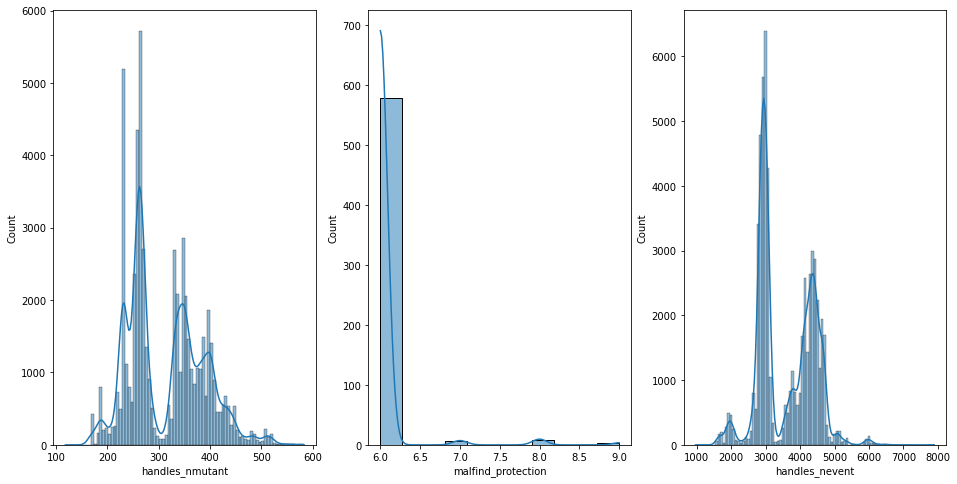

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(16,8))

sns.histplot(dfp['handles_nmutant'],kde=True,ax=ax[0])
sns.histplot(dfp.query('malfind_protection<10')['malfind_protection'],kde=True,ax=ax[1])
sns.histplot(dfp['handles_nevent'],kde=True,ax=ax[2])

In [30]:
##limpieza de datos, remover los 0 y negativos 
from pyspark.sql import functions as F
resumen_datos2= (resumen_datos2.withColumn("malware_id",
                   F.when(F.col("malware_id")<=0,1)
                   .otherwise(F.col("malware_id"))))

In [31]:
features=resumen_datos2.columns[1:]
print(features)

['malfind_protection', 'handles_nevent', 'malware_id']


In [32]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol='ret_features')

assembled_data= assembler.transform(resumen_datos2)
assembled_data= assembled_data.select('malware_id','ret_features')
assembled_data.show()

+----------+-------------------+
|malware_id|       ret_features|
+----------+-------------------+
|       254|[30.0,3161.0,254.0]|
|       391|[72.0,3761.0,391.0]|
|       335|[30.0,3996.0,335.0]|
|       239|[12.0,2961.0,239.0]|
|       426|[72.0,3834.0,426.0]|
|       379|[30.0,4308.0,379.0]|
|       396|[30.0,4727.0,396.0]|
|       426|[72.0,3835.0,426.0]|
|       426|[72.0,3836.0,426.0]|
|       380|[30.0,4321.0,380.0]|
|       397|[30.0,4671.0,397.0]|
|       426|[72.0,3829.0,426.0]|
|       380|[30.0,4314.0,380.0]|
|       397|[30.0,4650.0,397.0]|
|       426|[72.0,3829.0,426.0]|
|       380|[30.0,4299.0,380.0]|
|       384|[24.0,4452.0,384.0]|
|       333|[36.0,3515.0,333.0]|
|       380|[30.0,4299.0,380.0]|
|       378|[24.0,4447.0,378.0]|
+----------+-------------------+
only showing top 20 rows



In [34]:
# Se aplica Estandarizacion de escalas

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='ret_features',outputCol='ret_standard')
data_scale = scaler.fit(assembled_data)
standard_data = data_scale.transform(assembled_data)
standard_data.show()

+----------+-------------------+--------------------+
|malware_id|       ret_features|        ret_standard|
+----------+-------------------+--------------------+
|       254|[30.0,3161.0,254.0]|[0.32489663149799...|
|       391|[72.0,3761.0,391.0]|[0.77975191559518...|
|       335|[30.0,3996.0,335.0]|[0.32489663149799...|
|       239|[12.0,2961.0,239.0]|[0.12995865259919...|
|       426|[72.0,3834.0,426.0]|[0.77975191559518...|
|       379|[30.0,4308.0,379.0]|[0.32489663149799...|
|       396|[30.0,4727.0,396.0]|[0.32489663149799...|
|       426|[72.0,3835.0,426.0]|[0.77975191559518...|
|       426|[72.0,3836.0,426.0]|[0.77975191559518...|
|       380|[30.0,4321.0,380.0]|[0.32489663149799...|
|       397|[30.0,4671.0,397.0]|[0.32489663149799...|
|       426|[72.0,3829.0,426.0]|[0.77975191559518...|
|       380|[30.0,4314.0,380.0]|[0.32489663149799...|
|       397|[30.0,4650.0,397.0]|[0.32489663149799...|
|       426|[72.0,3829.0,426.0]|[0.77975191559518...|
|       380|[30.0,4299.0,380

In [35]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

costs = {}

for k in range(2,10):
  k_means = KMeans(featuresCol='ret_standard',k=k)
  model = k_means.fit(standard_data)
  #predictions = model.transform(standard_data)
  #evaluador = ClusteringEvaluator()
  #silueta = evaluador.evaluate(predictions)
  costs[k] = model.summary.trainingCost
  print(k)

2
3
4
5
6
7
8
9


Text(0, 0.5, 'handles_nevent')

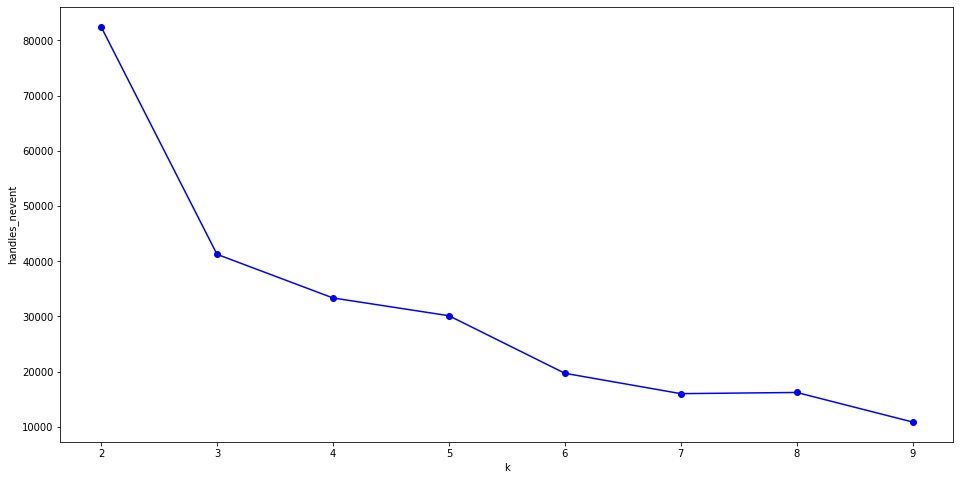

In [36]:
fig,ax = plt.subplots(1,1, figsize=(16,8))

ax.plot(list(costs.keys()),list(costs.values()),'-ob')
ax.set_xlabel('k')
ax.set_ylabel('handles_nevent')

In [37]:
k_means = KMeans(featuresCol='ret_standard',k=4)
model = k_means.fit(standard_data)
predictions = model.transform(standard_data)

In [38]:
result = predictions.select('malware_id', 'prediction')
result.show()

+----------+----------+
|malware_id|prediction|
+----------+----------+
|       254|         0|
|       391|         1|
|       335|         1|
|       239|         0|
|       426|         3|
|       379|         1|
|       396|         3|
|       426|         3|
|       426|         3|
|       380|         1|
|       397|         3|
|       426|         3|
|       380|         1|
|       397|         3|
|       426|         3|
|       380|         1|
|       384|         1|
|       333|         1|
|       380|         1|
|       378|         1|
+----------+----------+
only showing top 20 rows



In [39]:
dfp = result.join(resumen_datos2, on='malware_id', how='inner')
dfp

DataFrame[malware_id: int, prediction: int, handles_nmutant: int, malfind_protection: int, handles_nevent: int]

In [40]:
#Solución: Se aplica un limite de 1000 registros ya que el data set tiene muchos datos y al momento de hacer la conexión con Spark esta se cae
dfp_limit = dfp.limit(1000)
dfp_limit
dfp_limit.show()

+----------+----------+---------------+------------------+--------------+
|malware_id|prediction|handles_nmutant|malfind_protection|handles_nevent|
+----------+----------+---------------+------------------+--------------+
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257|                30|          3161|
|       254|         0|            257

In [41]:
print(dfp_limit.count(),len(dfp_limit.columns))

1000 5


In [42]:
dfc = dfp_limit.toPandas()

In [43]:
dfc

,malware_id,prediction,handles_nmutant,malfind_protection,handles_nevent
0,254,0,257,30,3161
1,254,0,257,30,3161
2,254,0,257,30,3161
3,254,0,257,30,3161
4,254,0,257,30,3161
...,...,...,...,...,...
995,335,1,338,30,3996
996,335,1,338,30,3996
997,335,1,338,30,3996
998,335,1,338,30,3996


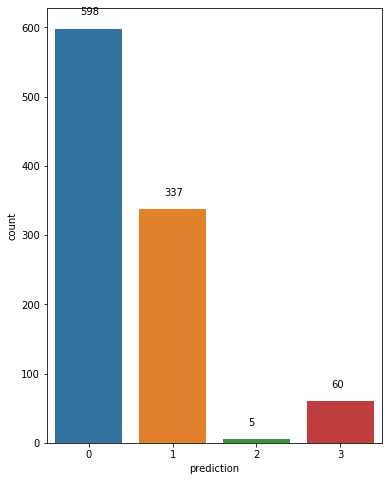

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=dfc)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

**En el siguiebte boxplot se puede observar como la cantidad de protección contra el virus ofuscado es poca, mientras que la cantidad de archivos mutantes es mayor y los eventos también.**

<AxesSubplot:xlabel='prediction', ylabel='handles_nevent'>

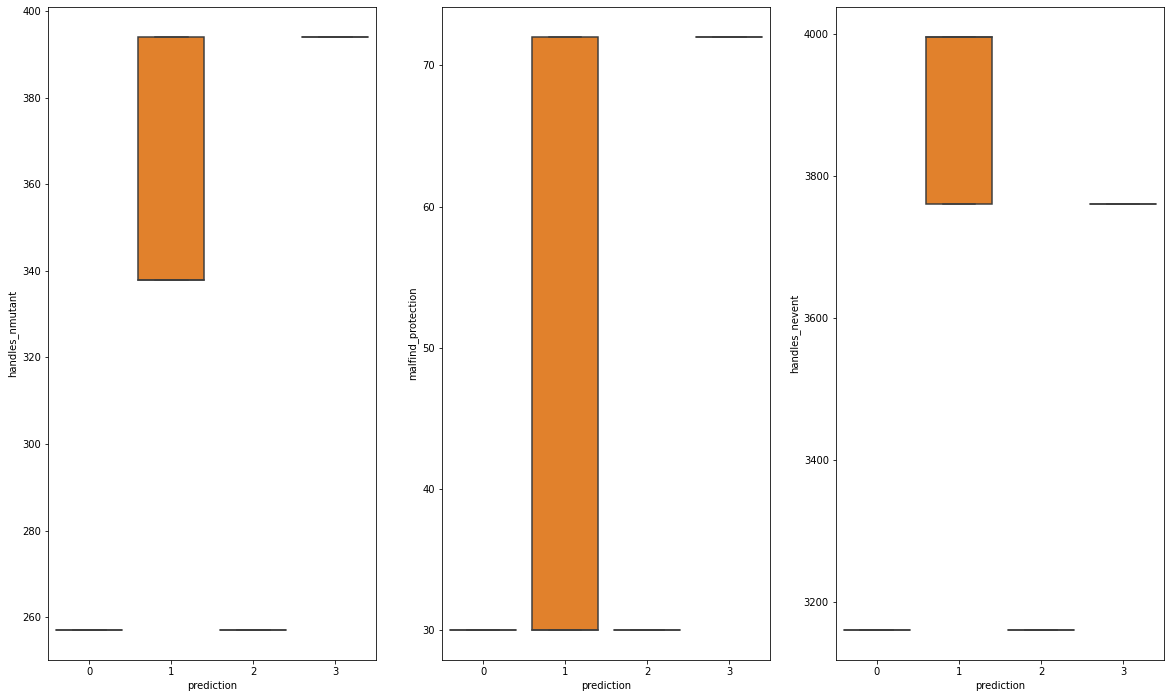

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='handles_nmutant', data=dfc, ax=ax[0])
sns.boxplot(x='prediction', y='malfind_protection', data=dfc, ax=ax[1])
sns.boxplot(x='prediction', y='handles_nevent', data=dfc, ax=ax[2])

*   En el primer gráfico se muestra que de 400 archivos mutantes solo se encuentran 70.
*   En el segundo gráfico se corrobora que la protección es baja de 3800 posibles eventos solo 70 se logran identificar.
*   En el último gráfico se puede observar que mientas más eventos haya hay más archivos mutantes.





<AxesSubplot:xlabel='handles_nmutant', ylabel='handles_nevent'>

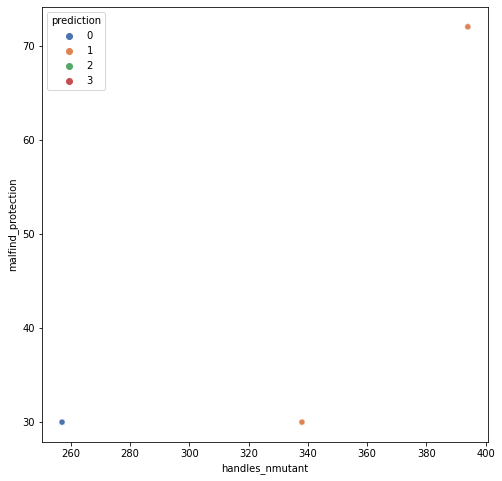

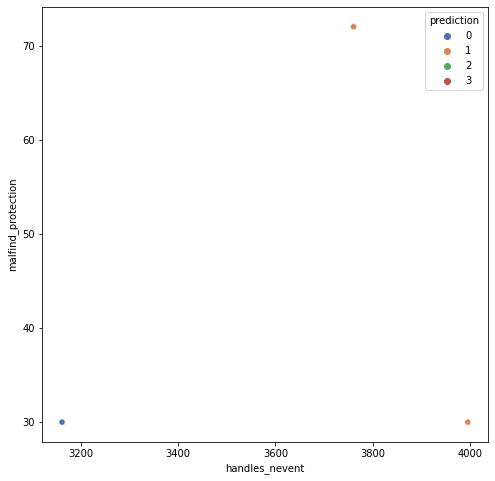

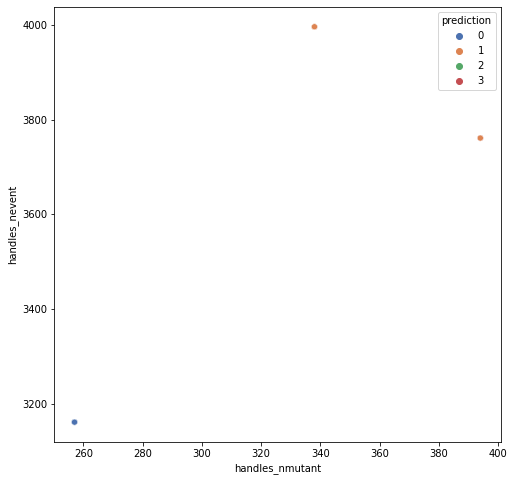

In [46]:
selected_result_df = dfc #.query('handles_nmutant < 10').query('malfind_protection < 30')

# handles_nmutant vs malfind_protection (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='handles_nmutant', y='malfind_protection', data=selected_result_df, hue='prediction', palette="deep")

# handles_nevent vs malfind_protection (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='handles_nevent', y='malfind_protection', data=selected_result_df, hue='prediction', palette="deep")

# handles_nmutant vs handles_nevent (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='handles_nmutant', y='handles_nevent', data=selected_result_df, hue='prediction', palette="deep")

In [47]:
analysis = dfp\
    .groupBy('prediction')\
    .agg(F.avg('handles_nmutant').alias('Avg La cantidad promedio de archivos mutantes'),
         F.avg('malfind_protection').alias('Avg La cantidad promedio de virus ofuscados'),
         F.avg('handles_nevent').alias('Avg La cantidad de eventos en la memoria'))

In [48]:
analysis.show()

+----------+---------------------------------------------+-------------------------------------------+----------------------------------------+
|prediction|Avg La cantidad promedio de archivos mutantes|Avg La cantidad promedio de virus ofuscados|Avg La cantidad de eventos en la memoria|
+----------+---------------------------------------------+-------------------------------------------+----------------------------------------+
|         1|                           348.83991050387715|                          23.18444597413299|                       4287.541285656049|
|         3|                            408.5401763835861|                         34.960196788038076|                       4415.717719333548|
|         2|                            262.2794663317973|                         192.03622400292943|                       2948.429438121972|
|         0|                           248.10767997549402|                          27.78407061201851|                      2900.1575914

# Metódo Gausiano - SPARK

In [49]:
from pyspark.ml.clustering import GaussianMixture

# loads data
#dataset = spark.read.csv('/content/drive/My Drive/datasets/retail_retention.csv',inferSchema=True,header=True)

gmm = GaussianMixture(featuresCol='ret_standard').setK(4).setSeed(4582)
model = gmm.fit(standard_data)

print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show(truncate=False)

Gaussians shown as a DataFrame: 
+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean                                                       |cov                                                                                                                                                                                                             |
+-----------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.2222508770189927,3.5463258791265653,3.34444406740207]   |0.10881511560356057   0.011295688052595008  0.010639121725422853  \n0.011295688052595008  0.1

In [50]:
predictions_gmm = model.transform(standard_data)
predictions_gmm.show()

+----------+-------------------+--------------------+--------------------+----------+
|malware_id|       ret_features|        ret_standard|         probability|prediction|
+----------+-------------------+--------------------+--------------------+----------+
|       254|[30.0,3161.0,254.0]|[0.32489663149799...|[0.99513159955689...|         0|
|       391|[72.0,3761.0,391.0]|[0.77975191559518...|[3.34286893223349...|         3|
|       335|[30.0,3996.0,335.0]|[0.32489663149799...|[0.00605358160745...|         3|
|       239|[12.0,2961.0,239.0]|[0.12995865259919...|[0.99895448232171...|         0|
|       426|[72.0,3834.0,426.0]|[0.77975191559518...|[1.24624927715600...|         3|
|       379|[30.0,4308.0,379.0]|[0.32489663149799...|[1.85615965875661...|         3|
|       396|[30.0,4727.0,396.0]|[0.32489663149799...|[1.71395714139543...|         3|
|       426|[72.0,3835.0,426.0]|[0.77975191559518...|[1.23933969798941...|         3|
|       426|[72.0,3836.0,426.0]|[0.77975191559518...|[

**Asignar los clusters resultantes al dataframe**

In [51]:
resumen_datos3 = predictions_gmm.join(resumen_datos2, on='malware_id', how='inner')
print(resumen_datos3)

DataFrame[malware_id: int, ret_features: vector, ret_standard: vector, probability: vector, prediction: int, handles_nmutant: int, malfind_protection: int, handles_nevent: int]


In [52]:
dfp_limit2 = resumen_datos3.limit(1000)
dfp_limit2
dfp_limit2.show()

+----------+-------------------+--------------------+--------------------+----------+---------------+------------------+--------------+
|malware_id|       ret_features|        ret_standard|         probability|prediction|handles_nmutant|malfind_protection|handles_nevent|
+----------+-------------------+--------------------+--------------------+----------+---------------+------------------+--------------+
|       254|[30.0,3161.0,254.0]|[0.32489663149799...|[0.99513159955689...|         0|            257|                18|          2887|
|       254|[30.0,3161.0,254.0]|[0.32489663149799...|[0.99513159955689...|         0|            257|                18|          2899|
|       254|[30.0,3161.0,254.0]|[0.32489663149799...|[0.99513159955689...|         0|            257|                18|          2891|
|       254|[30.0,3161.0,254.0]|[0.32489663149799...|[0.99513159955689...|         0|            257|                18|          2890|
|       254|[30.0,3161.0,254.0]|[0.3248966314979

In [53]:
dfc2 = dfp_limit2.toPandas()
dfc2

,malware_id,ret_features,ret_standard,probability,prediction,handles_nmutant,malfind_protection,handles_nevent
0,254,"[30.0, 3161.0, 254.0]","[0.3248966314979924, 3.924462978385636, 3.4712...","[0.9951315995568918, 5.338419663512752e-16, 0....",0,257,18,2887
1,254,"[30.0, 3161.0, 254.0]","[0.3248966314979924, 3.924462978385636, 3.4712...","[0.9951315995568918, 5.338419663512752e-16, 0....",0,257,18,2899
2,254,"[30.0, 3161.0, 254.0]","[0.3248966314979924, 3.924462978385636, 3.4712...","[0.9951315995568918, 5.338419663512752e-16, 0....",0,257,18,2891
3,254,"[30.0, 3161.0, 254.0]","[0.3248966314979924, 3.924462978385636, 3.4712...","[0.9951315995568918, 5.338419663512752e-16, 0....",0,257,18,2890
4,254,"[30.0, 3161.0, 254.0]","[0.3248966314979924, 3.924462978385636, 3.4712...","[0.9951315995568918, 5.338419663512752e-16, 0....",0,257,24,2942
...,...,...,...,...,...,...,...,...
995,335,"[30.0, 3996.0, 335.0]","[0.3248966314979924, 4.961137001464411, 4.5781...","[0.006053581607455306, 1.210112059914734e-15, ...",3,338,30,4018
996,335,"[30.0, 3996.0, 335.0]","[0.3248966314979924, 4.961137001464411, 4.5781...","[0.006053581607455306, 1.210112059914734e-15, ...",3,338,24,4106
997,335,"[30.0, 3996.0, 335.0]","[0.3248966314979924, 4.961137001464411, 4.5781...","[0.006053581607455306, 1.210112059914734e-15, ...",3,338,18,4364
998,335,"[30.0, 3996.0, 335.0]","[0.3248966314979924, 4.961137001464411, 4.5781...","[0.006053581607455306, 1.210112059914734e-15, ...",3,338,18,4369


**Hacer la interpretacion de los clusters**


**El metodo Gausiano demuestra que la protección contra el malware ofuscado es poca por parte de los antivirus**

<AxesSubplot:xlabel='handles_nevent', ylabel='Count'>

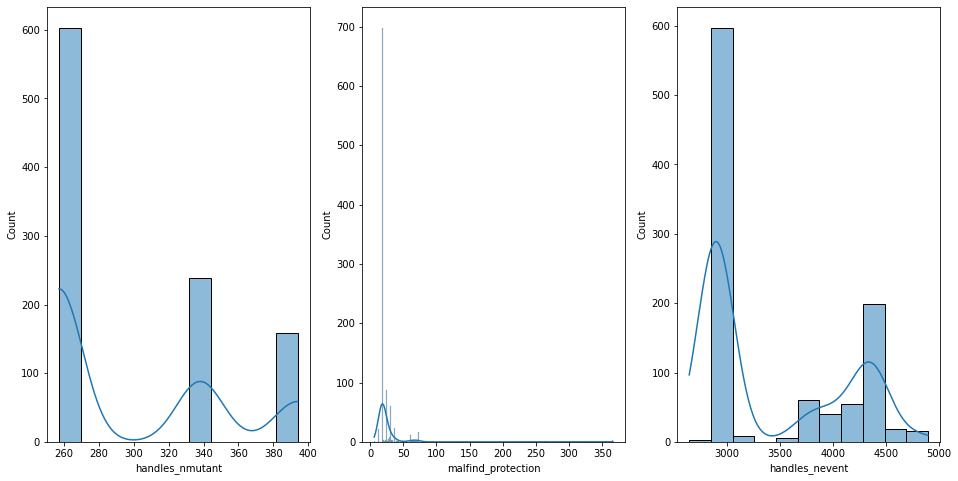

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,3,figsize=(16,8))

sns.histplot(dfc2['handles_nmutant'],kde=True,ax=ax[0])

sns.histplot(dfc2.query('malfind_protection < 1000')['malfind_protection'],kde=True,ax=ax[1])

sns.histplot(dfc2.query('handles_nevent < 10000')['handles_nevent'],kde=True,ax=ax[2])

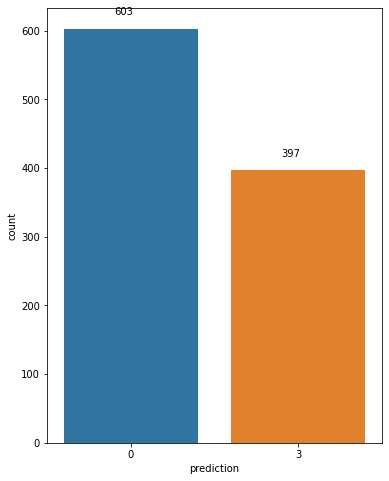

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=dfc2)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

<AxesSubplot:xlabel='prediction', ylabel='handles_nevent'>

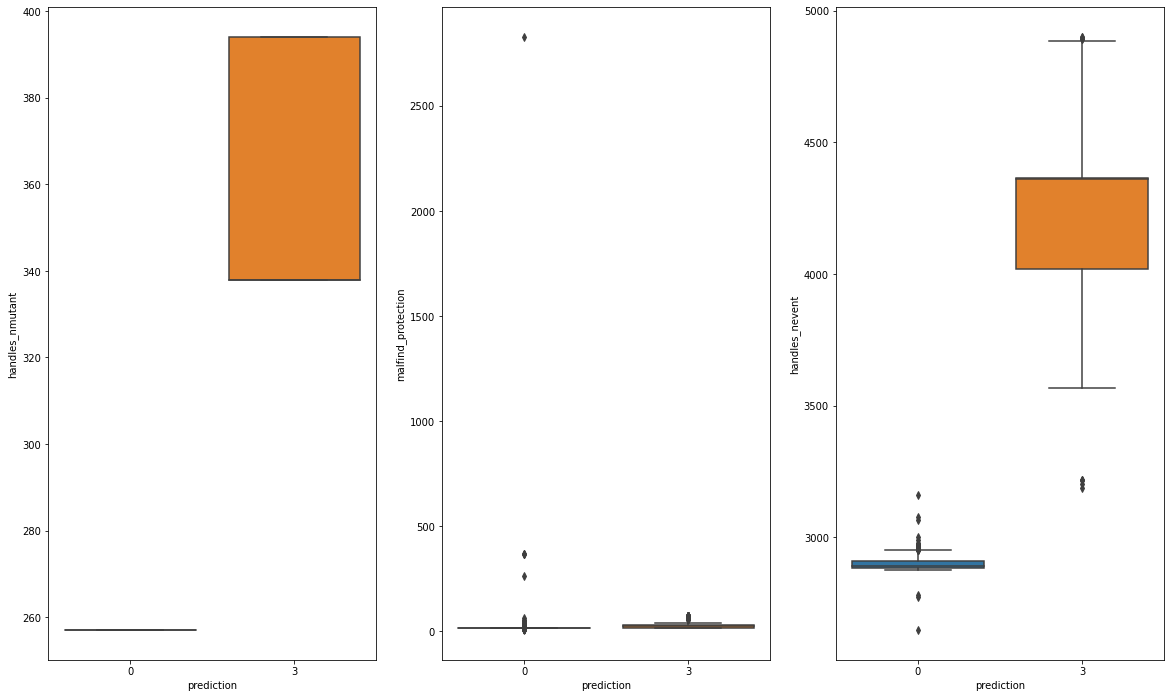

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='handles_nmutant', data=dfc2, ax=ax[0])
sns.boxplot(x='prediction', y='malfind_protection', data=dfc2, ax=ax[1])
sns.boxplot(x='prediction', y='handles_nevent', data=dfc2, ax=ax[2])

<AxesSubplot:xlabel='handles_nevent', ylabel='handles_nmutant'>

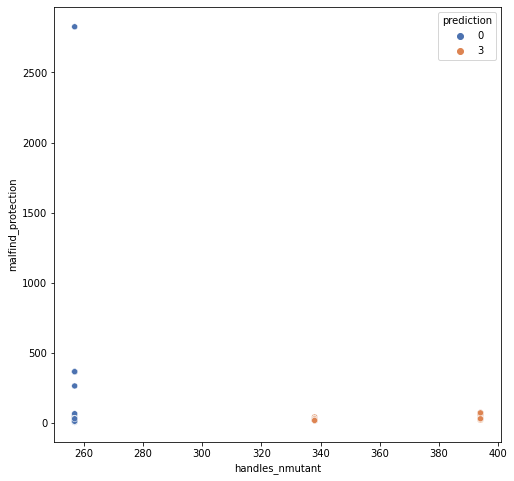

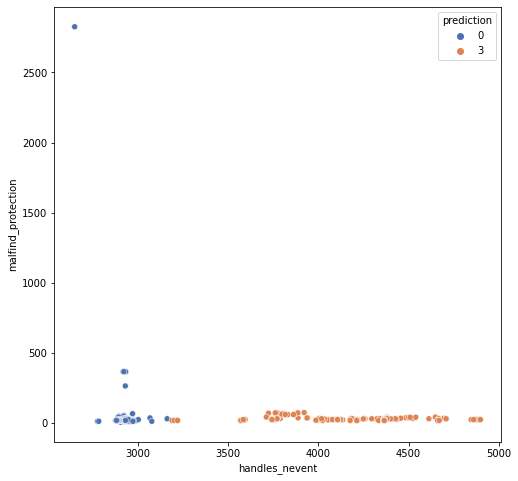

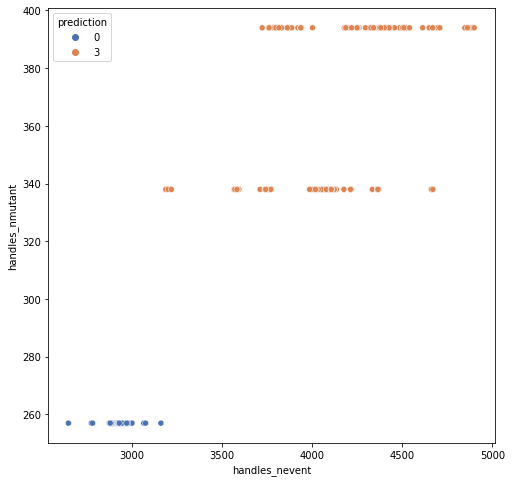

In [57]:
selected_result_df = dfc2 #.query('handles_nmutant < 100000').query('malfind_protection < 3000')

# handles_nmutant vs malfind_protection (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='handles_nmutant', y='malfind_protection', data=selected_result_df, hue='prediction', palette="deep")

# handles_nevent vs malfind_protection (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='handles_nevent', y='malfind_protection', data=selected_result_df, hue='prediction', palette="deep")

# handles_nevent vs handles_nmutant (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='handles_nevent', y='handles_nmutant', data=selected_result_df, hue='prediction', palette="deep")

# Conclusión

**En conclusión el entendimiento en ambos metódos es casi igual con la diferencia de que en el metodo Gausiano se enfoca más en las minorías, por otro lado el metódo Kmeans toma como referencia a un conjunto de datos más especificos, ambos metodos nos servirían de gran ayuda, solo depende de como queramos llevar nuestro analisis, en este caso, para la revisión del virus ofuscado, se recomienda utilizar el GMM ya que nos permitira ver de una forma más clara las minorías que son muy importantes en este caso para poder encontrar el virus ofuscado y las brechas que estos conllevan y así poder tomar soluciones optimas para poder estar preparados ante cualquier ameneza cibernetica.**